In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler


In [2]:
power = pd.read_csv("C:/Users/Bin/Documents/Datasets/EncDec-AD dataset/power_data_labeled.csv",names=["power_demand","label"])


In [3]:
test_set = power.iloc[84*13:,0]
label = power.iloc[84*13:,1]

In [4]:
test_set.shape

(3192,)

# Autoencoder anomaly detection

In [5]:

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time

## Reload power_demand autoencoder from disk

In [6]:
#modelpath_root ="C:/Users/Bin/Desktop/Thesis/tmp/EncDecADModel_online_init/power_demand/Try1_2_40_84/"
modelpath_root ="C:/Users/Bin/Desktop/Thesis/tmp/EncDecADModel_online_init/power_demand/Try8_1_40_84/"
modelmeta_p = modelpath_root + "LSTMAutoencoder_power_1_40_84_para.ckpt.meta"
step_num = 84
hidden_num = 40
batch_num = 1
elem_num = 1

In [7]:
#test_set_list = [test_set.iloc[:3192,0].as_matrix().reshape(19,2,84,1)[a] for a in range(19)]
test_set_list = [test_set.as_matrix().reshape(38,1,84,1)[a] for a in range(38)]

In [8]:
sess = tf.Session()
saver = tf.train.import_meta_graph(modelmeta_p) # load trained gragh, but without the trained parameters
saver.restore(sess,tf.train.latest_checkpoint(modelpath_root))
graph = tf.get_default_graph()

p_input = graph.get_tensor_by_name("p_input:0")
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)] 
#        p_is_training = tf.placeholder(tf.bool)
p_is_training = graph.get_tensor_by_name("is_training_:0")

input_= tf.transpose(tf.stack(p_inputs), [1, 0, 2])    
output_ = graph.get_tensor_by_name("decoder/output_:0")

tensor_mu = graph.get_tensor_by_name("mu:0")
tensor_sigma = graph.get_tensor_by_name("sigma:0")
tensor_threshold = graph.get_tensor_by_name("threshold:0")

loss_ = graph.get_tensor_by_name("decoder/loss:0")
train_ = graph.get_operation_by_name("cond/train_")

mu = sess.run(tensor_mu)
sigma = sess.run(tensor_sigma)
threshold = sess.run(tensor_threshold)

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/EncDecADModel_online_init/power_demand/Try8_1_40_84/LSTMAutoencoder_power_1_40_84_para.ckpt


In [9]:
print(mu,sigma,threshold)

0.0741361 0.00367177 0.158081


# Retrain according to performance

## 2. retrain when prediction performance < t

In [10]:
from scipy.spatial.distance import mahalanobis,euclidean
eta = 0.6 #privous parameters plays 60% role during the parameter updating

In [11]:
def scoring(err,mu,sigma,batch_num,step_num):
    scoreBuffer = []
    for window in range(batch_num):
        for t in range(step_num):
            s = euclidean(mu,err[window,t,0])
            scoreBuffer.append(s)
    return scoreBuffer

In [12]:
def update_parameter(errBuffer,mu,sigma,eta,threshold,score):       
        tmp_errBuffer = errBuffer[-3:] if len(errBuffer)>3 else errBuffer
        err_vec_array = np.array(tmp_errBuffer)
        # for univariate  data
        __mu = np.mean(err_vec_array.ravel())
        mu = mu*eta + __mu*(1-eta)

        __sigma =np.var(err_vec_array.ravel())
        sigma = __sigma
        
        # only normal batch could trigger the parameter uodate, so adjust the threshold to the new seen normal data scores
        threshold = threshold*eta + np.mean(score)*(1-eta)
        return mu,sigma,threshold

In [13]:
def evaluate(threoshld,scores,label):
    beta = 1
    tn = len(set(scores[ scores > threshold].index) & set( label[label=='anomaly'].index))
    fp = len(set(scores[ scores > threshold].index) & set(label[label=='normal'].index))
    fn = len(set(scores[ scores <= threshold].index) & set( label[label=='anomaly'].index))
    tp = len(set(scores[ scores <= threshold].index) & set(label[label=='normal'].index))
    #tp = abnormal_score[abnormal_score>threshold].size
    #fp = abnormal_score.size-tp
    #fn = normal_score[normal_score>threshold].size
    #tn = normal_score.size- fn

    if tp == 0: 
        print("TP is 0.")
        return 0
    

    P = tp/(tp+fp) # reduce the number of didn't detected anomaly
    R = tp/(tp+fn) # recuce the number of normal points that predicted as abnormal
    fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
    print(tp,fp,fn,tn,fbeta,threshold)
    return fbeta,tp, tn

In [14]:
input_buffer = []
output_buffer = []
#anomaly_batches = [0,2,3,18]
anomaly_batches = [3,4,6,25,37]
count = -1
loss_overall = []
err_sum_0 = 0
dataBuffer = []
scoreBuffer = []
scoreWinBuffer = []
a_scoreBuffer = []
n_scoreBuffer = []
errBuffer = []
errSumBuffer = []
fbeta = []
tpBuffer = []
tnBuffer = []
label_list = []
retrainPos = []
thresholdBuffer = []
for data in test_set_list:
    count +=1
    (input_n, output_n) = sess.run([input_, output_], {p_input: data, p_is_training: False})
    
    input_buffer.append(input_n)
    output_buffer.append(output_n)
    
    err = abs(input_n-output_n).reshape(-1,step_num,elem_num)
    errBuffer.append(err)
    scores = scoring(err,mu,sigma,batch_num,step_num)
    scoreBuffer += scores
    scores = pd.Series(scores)
    scoreWinBuffer.append(scores[scores > threshold].size)#(max(scores))
    
    batch_label = label[count*step_num*batch_num:(count+1)*step_num*batch_num].reset_index(drop=True)
    label_list.append(batch_label)
    f,tp, tn = evaluate(threshold,scores,batch_label)
    fbeta.append(f)
    tpBuffer.append(tp)
    tnBuffer.append(tn)
    
    if count == 0:
        err_sum_0 = sum(abs(input_n- output_n).ravel())
     
    thresholdBuffer.append(threshold)
    # update parameters, if make wrong prediction
    
    scores = pd.Series(scores)
    
    error_sum = sum(abs(input_n-output_n).ravel())
    
    errSumBuffer.append(error_sum)
    
    '''
    if scores[scores > threshold].size >= 3: # if 3 anomaly point detected within a week, then treat this week as anomaly
        if count in anomaly_batches:
            print("Correct alarm!!!")
            continue
        else:
            dataBuffer.append(data)
            print("Wrong alarm! Use this batch to update parameters...")
            #mu,sigma,threshold = update_parameter(errBuffer,mu,sigma,eta,threshold,scores)
           
    else:
        if count in anomaly_batches:
            print("Miss alarm! Use this batch to update parameters...")       
            #mu,sigma,threshold = update_parameter(errBuffer,mu,sigma,eta,threshold,scores)
            continue
        else:
            print("Correct prediction!!!")
            dataBuffer.append(data)
    
    if f < 0.95 :
        mu,sigma,threshold = update_parameter(errBuffer,mu,sigma,eta,threshold,scores)
        print("Parameters updated!")
    

    # retrain autoencoder, when sum reconstruction error larger than initial max r.error
    
    error_sum = sum(abs(input_n-output_n).ravel())
    
    errSumBuffer.append(error_sum)
    if error_sum >= err_sum_0+0.5 or count ==0:
        retrainPos.append(count)
        print("Retrain at batch number %d\n"%count)
        buffer = dataBuffer[-3:] if len(dataBuffer)>3 else dataBuffer
        loss = []
        for i in range(100):
            ind = np.random.randint(0,len(buffer))
            d = buffer[ind]
            (loss_val, _) = sess.run([loss_, train_], {p_input: d,p_is_training : True})
            loss.append(loss_val)
            print('Retrain-iter %d:' % (i + 1), loss_val)
        loss_overall.append(loss_val)
        pd.Series(loss).plot(title="Loss")
    '''

81 3 0 0 0.9818181818181818 0.158081
80 4 0 0 0.975609756097561 0.158081
80 4 0 0 0.975609756097561 0.158081
63 9 3 9 0.9130434782608695 0.158081
55 5 6 18 0.9090909090909091 0.158081
81 3 0 0 0.9818181818181818 0.158081
68 4 3 9 0.951048951048951 0.158081
81 3 0 0 0.9818181818181818 0.158081
81 3 0 0 0.9818181818181818 0.158081
81 3 0 0 0.9818181818181818 0.158081
81 3 0 0 0.9818181818181818 0.158081
77 7 0 0 0.9565217391304348 0.158081
79 5 0 0 0.9693251533742331 0.158081
82 2 0 0 0.9879518072289156 0.158081
79 5 0 0 0.9693251533742331 0.158081
80 4 0 0 0.975609756097561 0.158081
81 3 0 0 0.9818181818181818 0.158081
81 3 0 0 0.9818181818181818 0.158081
80 4 0 0 0.975609756097561 0.158081
84 0 0 0 1.0 0.158081
82 2 0 0 0.9879518072289156 0.158081
84 0 0 0 1.0 0.158081
84 0 0 0 1.0 0.158081
80 4 0 0 0.975609756097561 0.158081
81 3 0 0 0.9818181818181818 0.158081
67 5 9 3 0.9054054054054054 0.158081
83 1 0 0 0.9940119760479043 0.158081
84 0 0 0 1.0 0.158081
83 1 0 0 0.9940119760479043 0

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


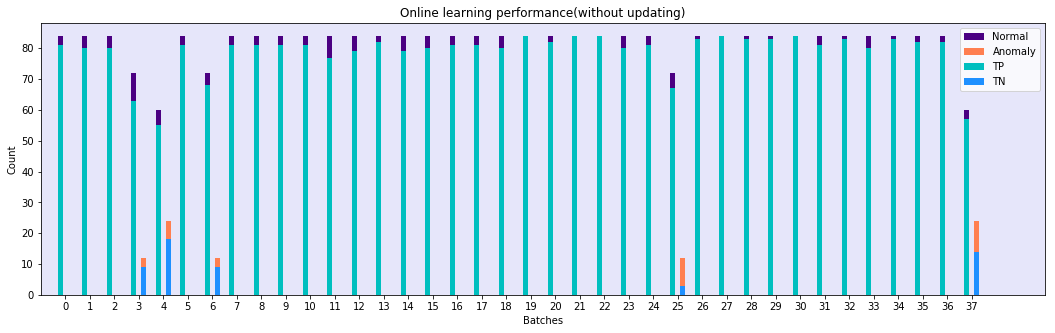

In [15]:
plt.figure(figsize=(18,5))
ax = plt.subplot(111,axisbg='lavender')
x = np.array((range(len(test_set_list))))
nSum = [len(l[l=='normal']) for  l in label_list]
aSum = [len(l[l=='anomaly']) for  l in label_list]
ax.bar(x-0.2,nSum,width=0.2,color='indigo',align='center',label='Normal')
ax.bar(x+0.2,aSum,width=0.2,color='coral',align='center',label='Anomaly')
ax.bar(x-0.2,tpBuffer,width=0.2,color='c',align='center',label='TP')
ax.bar(x+0.2,tnBuffer,width=0.2,color='dodgerblue',align='center',label='TN')


#pd.Series(np.ones(p1_error_n['max'].size)*p1_error_n['max'][0]).plot(label='error.max[0]',color='grey')
#ax.autoscale(tight=True)
plt.legend()
plt.xlim(-1,40)
plt.xlabel("Batches")
plt.ylabel("Count")
plt.title("Online learning performance(without updating)")

plt.xticks(range(38))
plt.show()

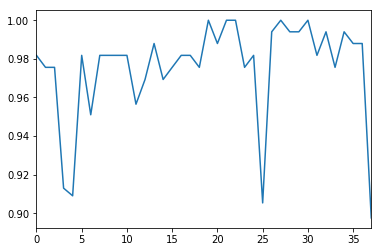

In [16]:
pd.Series(fbeta).plot()

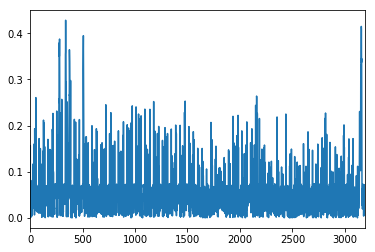

In [17]:
pd.Series(scoreBuffer).plot() # 12

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


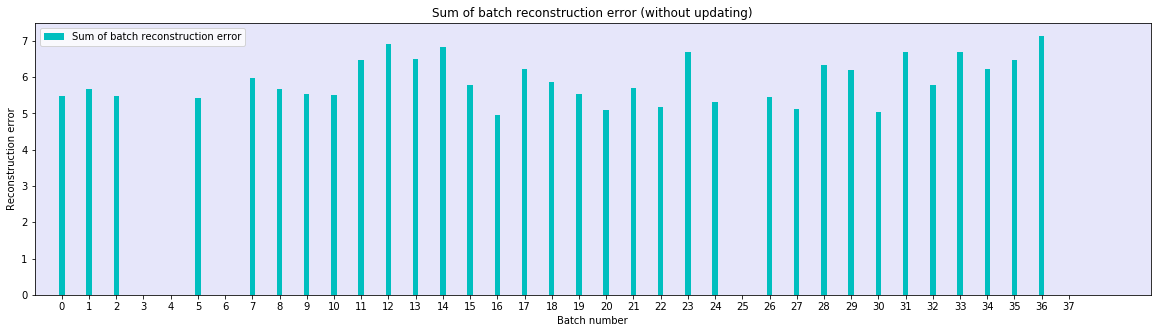

In [18]:
plt.figure(figsize=(20,5))
ax = plt.subplot(111,axisbg='lavender')
x = set(np.array((range(len(test_set_list)))))-set(anomaly_batches)
ax.bar(list(x),pd.Series(errSumBuffer)[x],width=0.2,color='c',align='center',label='Sum of batch reconstruction error')
#ax.bar(anomaly_batches,y,width=0.2,color='deeppink',align='center',label='Sum of batch reconstruction error')
#ax.bar([9,17,20,24,31],pd.Series(errSumBuffer)[[9,17,17,24,31]],width=0.2,color='chocolate',align='center',label="retrain after these batches")
plt.legend()
plt.xlabel("Batch number")
plt.ylabel("Reconstruction error")
plt.title("Sum of batch reconstruction error (without updating)")
plt.xlim(-1,40)
plt.xticks(range(38))
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


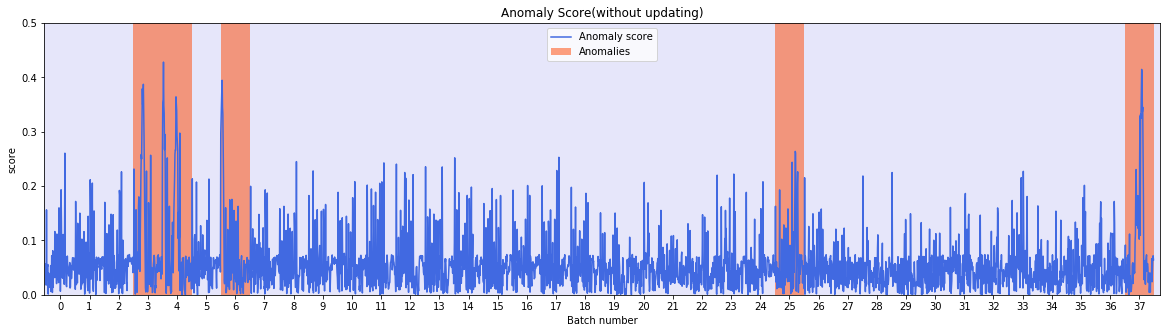

In [19]:
plt.figure(figsize=(20,5))
ax = plt.subplot(111,axisbg='lavender')
x = np.array(range(len(label)))
#xA = x[label=='anomaly']
#yA = pd.Series(scoreBuffer)[xA]
#ax.(x[:],scoreBuffer[:],width=0.2,color='r',align='center',label='Reconstruction error (Normal)')
ax.plot(scoreBuffer[:],color='royalblue',label='Anomaly score')
#ax.bar(xA,yA,width=0.2,color='tomato',align='center',label='Reconstruction error(Anomaly)')

plt.ylim(0,0.5)
plt.xlim(-5,3210)
plt.xlabel("Batch number")
plt.ylabel("score")
plt.title("Anomaly Score(without updating)")
plt.xticks([84*i+42 for i in range(len(test_set_list)) ],range(len(test_set_list)))
xs = [i*step_num for i in anomaly_batches]
ys = [(i+1)*step_num for i in anomaly_batches]
for i in range(len(xs)):
    plt.axvspan(xs[i], ys[i], facecolor='orangered', alpha=0.5,label='Anomalies')
    if i == 0:
        plt.legend()
        
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


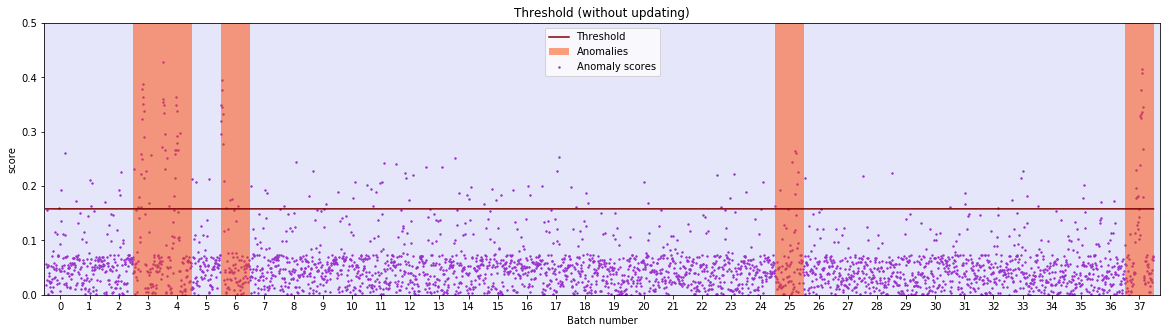

In [20]:
plt.figure(figsize=(20,5))
ax = plt.subplot(111,axisbg='lavender')
x = np.array(range(len(label)))
ax.scatter(x[:],scoreBuffer[:],color='darkorchid',s=2,label='Anomaly scores')
t = np.array([[tmp for _ in range(step_num)] for tmp in thresholdBuffer]).ravel()
ax.plot(t,color='maroon',label='Threshold')

plt.ylim(0,0.5)
plt.xlim(-5,3210)
plt.xlabel("Batch number")
plt.ylabel("score")
plt.title("Threshold (without updating)")

#xs = [i+1 for i in range(label.size-1) if (label[i] =='normal') & (label[i+1]=='anomaly')]
#ys = [i for i in range(label.size-1) if (label[i] =='anomaly') & (label[i+1]=='normal')]
xs = [i*step_num for i in anomaly_batches]
ys = [(i+1)*step_num for i in anomaly_batches]
for i in range(len(xs)):
    plt.axvspan(xs[i], ys[i], facecolor='orangered', alpha=0.5,label='Anomalies')
    if i == 0:
        plt.legend()
plt.xticks([84*i+42 for i in range(len(test_set_list)) ],range(len(test_set_list)))
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


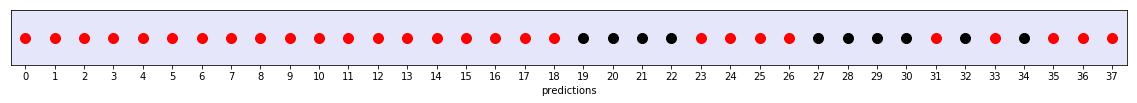

In [67]:
plt.figure(figsize=(20,1))
ax = plt.subplot(111,axisbg='lavender')
ax.scatter([19,20,21,22,27,28,29,30,32,34],[1 for _ in range(10)],color='black',s=100,label='Anomaly scores')
ax.scatter(list(set(range(38))-set([19,20,21,22,27,28,29,30,32,34])),[1 for _ in range(28)],color='r',s=100,label='Anomaly scores')
plt.xticks(range(38),range(38))
plt.xlabel("predictions")
plt.yticks(range(1),[])
plt.xlim(-0.5,37.5)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


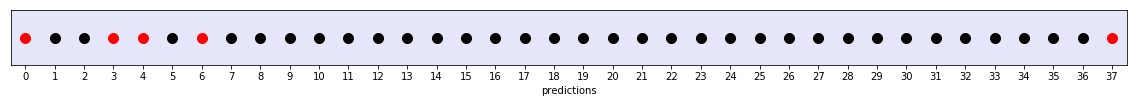

In [71]:
plt.figure(figsize=(20,1))
ax = plt.subplot(111,axisbg='lavender')
ax.scatter([0,3,4,6,37],[1 for _ in range(5)],color='r',s=100,label='Anomaly scores')
ax.scatter(list(set(range(38))-set([0,3,4,6,37])),[1 for _ in range(33)],color='black',s=100,label='Anomaly scores')
plt.xticks(range(38),range(38))
plt.xlabel("predictions")
plt.yticks(range(1),[])
plt.xlim(-0.5,37.5)
plt.show()

In [239]:
foo = pd.Series(np.array(input_buffer).ravel())
bar = pd.Series(np.array(output_buffer).ravel())
foobar = pd.concat((foo,bar),axis=1)

#foobar.to_csv("C:/Users/Bin/Desktop/Thesis/Synthetic example (Power demand dataset)/retrain_p1/retraining_if_error_larger_than_error0.csv",header=['input','output'],index=None)

In [23]:
# reconstruction error of normal data(retrain after each batch)

normal =pd.DataFrame( foobar[label[1008+84:]== 'normal'])
abnormal =pd.DataFrame( foobar[label[1008+84:]== 'anomaly'])

error1 = abs( normal[0]- normal[1])
error2 = abs( abnormal[0]- abnormal[1])
error1.plot()
error2.plot()
plt.xlim(-30,error1.size+error2.size)
plt.title("Reconstruction error (retrain_if_error_larger_than_error0)")
print("Normal: Max %.2f, min %.2f, avg %.2f, median %.2f"%(max(error1),min(error1), np.mean(error1),np.median(error1)))
print("Abnormal: Max %.2f, min %.2f, avg %.2f, median %.2f"%(max(error2),min(error2), np.mean(error2),np.median(error2)))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match

In [34]:
# statistical results in batch
normal_batches = [error1[i*(batch_num*step_num):(i+1)*(batch_num*step_num)]for i in range(error1.size//(batch_num*step_num))]
abnormal_batches = [error2[i*(batch_num*step_num):(i+1)*(batch_num*step_num)]for i in range(error2.size//(batch_num*step_num))]

batch_error1  = pd.DataFrame([[max(x),min(x),np.mean(x),np.median(x)] for x in normal_batches])
batch_error2  = pd.DataFrame([[max(y),min(y),np.mean(y),np.median(y)] for y in abnormal_batches])

#batch_error1.to_csv("C:/Users/Bin/Desktop/Thesis/Synthetic example (Power demand dataset)/retrain_p1/normal_retraining(batch).csv",header=['max','min','avg','median'],index=None)
#batch_error2.to_csv("C:/Users/Bin/Desktop/Thesis/Synthetic example (Power demand dataset)/retrain_p1/abnormal_retraining(batch).csv",header=['max','min','avg','median'],index=None)


In [35]:
error0 =  abs( foobar[0]- foobar[1])
all_batches = [error0[i*(batch_num*step_num):(i+1)*(batch_num*step_num)]for i in range(error0.size//(batch_num*step_num))]
batch_error0  = pd.DataFrame([[max(x),min(x),np.mean(x),np.median(x)] for x in all_batches])
batch_error0.to_csv("C:/Users/Bin/Desktop/Thesis/Synthetic example (Power demand dataset)/retrain_p1/all_retraining(batch).csv",header=['max','min','avg','median'],index=None)


In [240]:
data = foobar
#data = pd.read_csv("C:/Users/Bin/Desktop/Thesis/Synthetic example (Power demand dataset)/retrain_p1/retraining_if_error_larger_than_error0.csv")

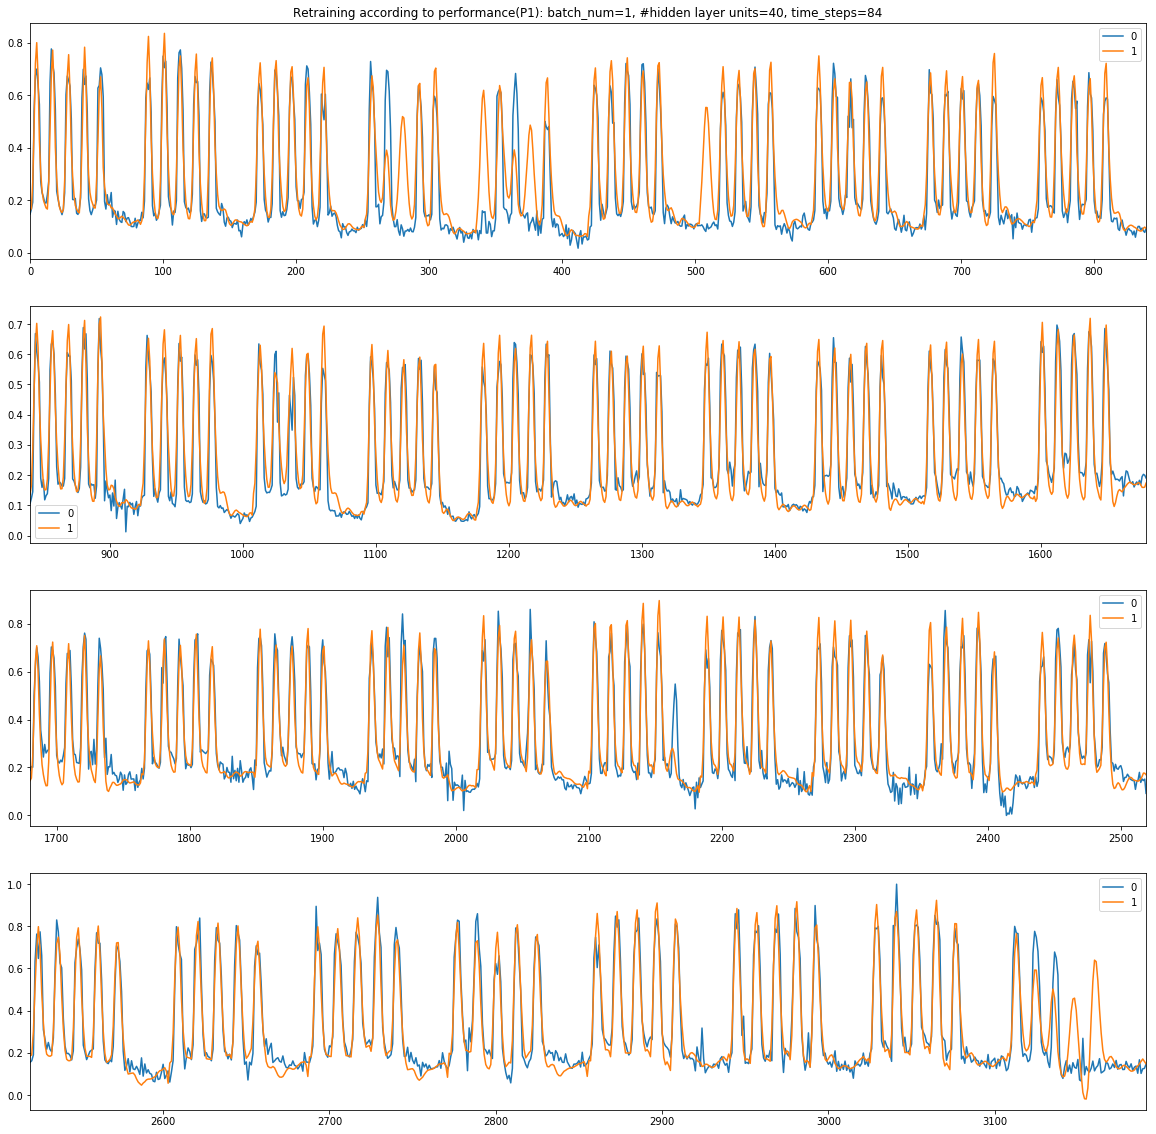

In [241]:
fig, axes = plt.subplots(nrows=4, ncols=1,figsize=(20,20))
axes[0].set_title("Retraining according to performance(P1): batch_num=1, #hidden layer units=40, time_steps=84")
data[:840].plot(ax=axes[0])
data[840*1:840*2].plot(ax=axes[1])
data[840*2:840*3].plot(ax=axes[2])
data[840*3:].plot(ax=axes[3])


(0, 1)

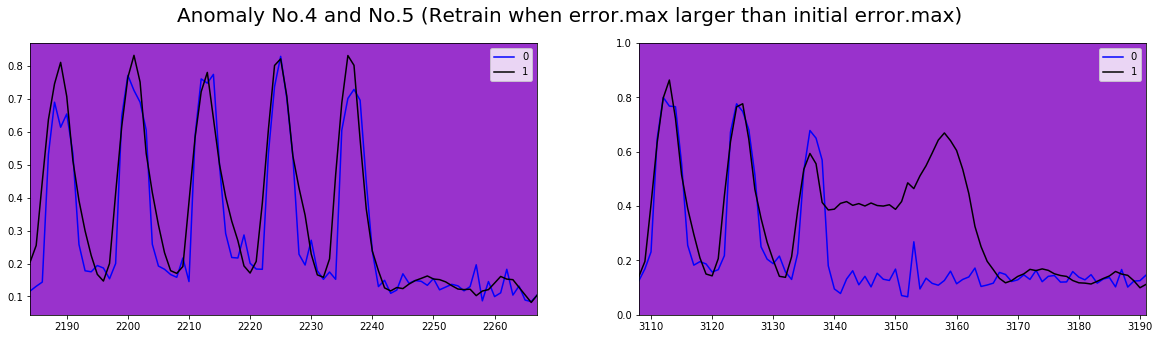

In [42]:
fig, (ax0,ax1) = plt.subplots(nrows=1, ncols=2,figsize=(20,5))
plt.suptitle("Anomaly No.4 and No.5 (Retrain when error.max larger than initial error.max)", fontsize=20)
data[84*26:84*27].plot(ax=ax0,color=['blue','black'])
data[-84:].plot(ax=ax1,color=['blue','black'])
ax0.set_facecolor('darkorchid')
ax1.set_facecolor('darkorchid')
plt.ylim(0,1)

(0, 0.8)

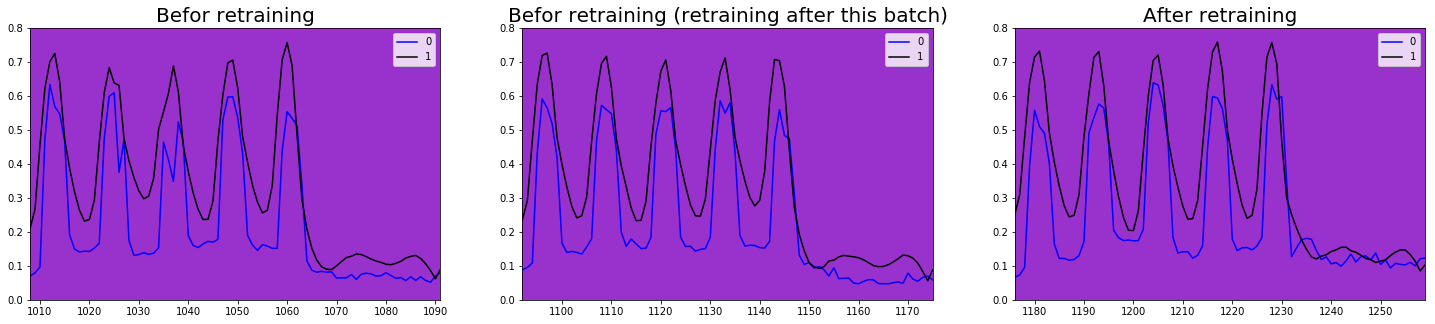

In [43]:
fig, (ax0,ax1,ax2) = plt.subplots(nrows=1, ncols=3,figsize=(25,5))
#plt.suptitle("Befor & after retraining")
data[84*12:84*13].plot(ax=ax0,color=['blue','black'])
data[84*13:84*14].plot(ax=ax1,color=['blue','black'])
data[84*14:84*15].plot(ax=ax2,color=['blue','black'])
ax0.set_facecolor('darkorchid')
ax1.set_facecolor('darkorchid')
ax2.set_facecolor('darkorchid')
ax0.set_title("Befor retraining", fontsize=20)
ax1.set_title("Befor retraining (retraining after this batch)", fontsize=20)
ax2.set_title("After retraining", fontsize=20)
ax0.set_ylim(0,0.8)
ax1.set_ylim(0,0.8)
ax2.set_ylim(0,0.8)

In [42]:
foo = pd.read_csv("C:/Users/Bin/Documents/Datasets/EncDec-AD dataset/normal.csv",header=None)
bar = pd.read_csv("C:/Users/Bin/Documents/Datasets/EncDec-AD dataset/abnormal.csv",header=None)


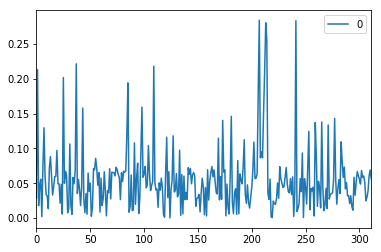

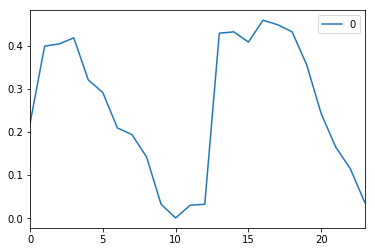

In [43]:
foo.plot()
bar.plot()

In [84]:
upper = max(foo.max()[0],bar.max()[0])
lower = foo.max()[0]
threshold = 0
result = 0
scala = 20
delta = (upper-lower) / scala
candidate = lower
def evaluate(threshold,normal_score,abnormal_score):

    beta = 1
    tp = abnormal_score[abnormal_score>threshold].size
    fp = abnormal_score.size-tp
    fn = normal_score[normal_score>threshold].size
    tn = normal_score.size- fn

    if tp == 0: return 0

    P = tp/(tp+fp) # reduce the number of didn't detected anomaly
    R = tp/(tp+fn) # recuce the number of normal points that predicted as abnormal
    fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
    print(tp,fp,fn,tn,fbeta,threshold)
    return fbeta 

for _ in range(scala):
    r = evaluate(candidate,foo.as_matrix(),bar.as_matrix())
    
    if r > result:
        result = r 
        threshold = candidate
    candidate += delta 

12 12 0 312 0.6666666666666666 0.284109950066
11 13 0 312 0.6285714285714286 0.292871934175
11 13 0 312 0.6285714285714286 0.301633918285
11 13 0 312 0.6285714285714286 0.310395902395
11 13 0 312 0.6285714285714286 0.319157886505
10 14 0 312 0.5882352941176471 0.327919870615
10 14 0 312 0.5882352941176471 0.336681854725
10 14 0 312 0.5882352941176471 0.345443838835
10 14 0 312 0.5882352941176471 0.354205822945
9 15 0 312 0.5454545454545454 0.362967807055
9 15 0 312 0.5454545454545454 0.371729791164
9 15 0 312 0.5454545454545454 0.380491775274
9 15 0 312 0.5454545454545454 0.389253759384
9 15 0 312 0.5454545454545454 0.398015743494
7 17 0 312 0.45161290322580644 0.406777727604
6 18 0 312 0.4 0.415539711714
5 19 0 312 0.3448275862068966 0.424301695824
2 22 0 312 0.15384615384615385 0.433063679934
2 22 0 312 0.15384615384615385 0.441825664043
1 23 0 312 0.07999999999999999 0.450587648153


In [292]:
threshold =0.28410995006561279

In [293]:
mu = 0.0672788

In [294]:
sigma = 0.0032714